# **About Datasets**

ChatGPT has been a major talk in the tech world. The tweets about chatgpt were gathered for a month and then the sentiment analysis was made using Natural Language Processing.

**Features**
*   Tweets	: text of tweet data
*   abels	: class of sentiment (good, bad, neutral)


# **Import Library & Datasets**

---

In [1]:
# Commented out IPython magic to ensure Python compatibility.
import pandas as pd
import numpy as np
import seaborn as sns
import re
import nltk
import tensorflow as tf
import matplotlib.pyplot as plt
import string
import keras.backend as K

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.layers import Dense,Conv1D,MaxPooling1D
from keras import models
from keras import layers
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

In [2]:
df=pd.read_csv('data_pangkas.csv')

In [3]:
df.head()

,tweets,labels
0,openais chatgpt is the worlds best chatbot by,good
1,i tried to ask chatgpt the last question glad...,good
2,you got to love chatgpt decoding urls for mast...,good
3,chatgpt is phenomenal but im not jumping on th...,bad
4,chatgpt proves ai is finally mainstream and th...,bad


In [4]:
df['labels'].value_counts()

labels
good       40000
bad        40000
neutral    40000
Name: count, dtype: int64

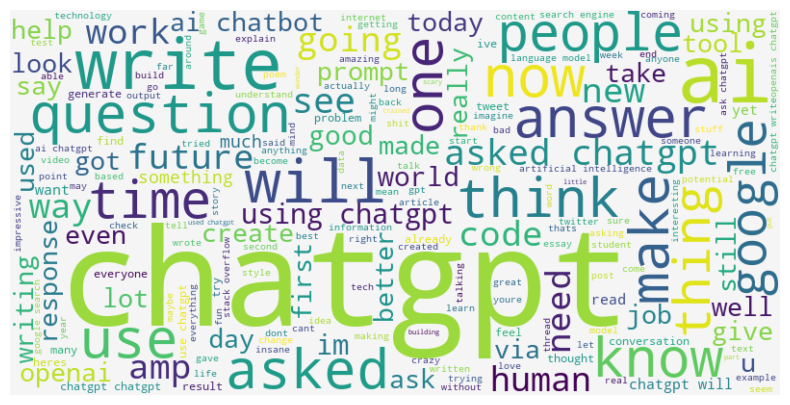

In [5]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt


text_df = df['tweets'].str.cat(sep=' ')

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=400, background_color='#F5F5F5').generate(text_df)

# Display the word cloud using Matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## **Bagian lain preprocessing**

In [6]:

tokenized_tweet = df['tweets'].apply(lambda x: word_tokenize(x))
tokenized_tweet.head()

0    [openais, chatgpt, is, the, worlds, best, chat...
1    [i, tried, to, ask, chatgpt, the, last, questi...
2    [you, got, to, love, chatgpt, decoding, urls, ...
3    [chatgpt, is, phenomenal, but, im, not, jumpin...
4    [chatgpt, proves, ai, is, finally, mainstream,...
Name: tweets, dtype: object

In [7]:
"""### Lemmatization"""

lemmatizer = WordNetLemmatizer()
tokenized_tweet = tokenized_tweet.apply(lambda sentence: [lemmatizer.lemmatize(word) for word in sentence])
tokenized_tweet.head()

for i in range(len(tokenized_tweet)):
    tokenized_tweet[i] = " ".join(tokenized_tweet[i])

df['clean_data'] = tokenized_tweet
df.head()

,tweets,labels,clean_data
0,openais chatgpt is the worlds best chatbot by,good,openais chatgpt is the world best chatbot by
1,i tried to ask chatgpt the last question glad...,good,i tried to ask chatgpt the last question glad ...
2,you got to love chatgpt decoding urls for mast...,good,you got to love chatgpt decoding url for masto...
3,chatgpt is phenomenal but im not jumping on th...,bad,chatgpt is phenomenal but im not jumping on th...
4,chatgpt proves ai is finally mainstream and th...,bad,chatgpt prof ai is finally mainstream and thin...


In [8]:
print(df['clean_data'].isnull().sum())  # Jumlah NaN

0


In [9]:
df['labels'].value_counts()

labels
good       40000
bad        40000
neutral    40000
Name: count, dtype: int64

# **Bagian Yang Lain**

**Word Cloud data, setelah cleaning**

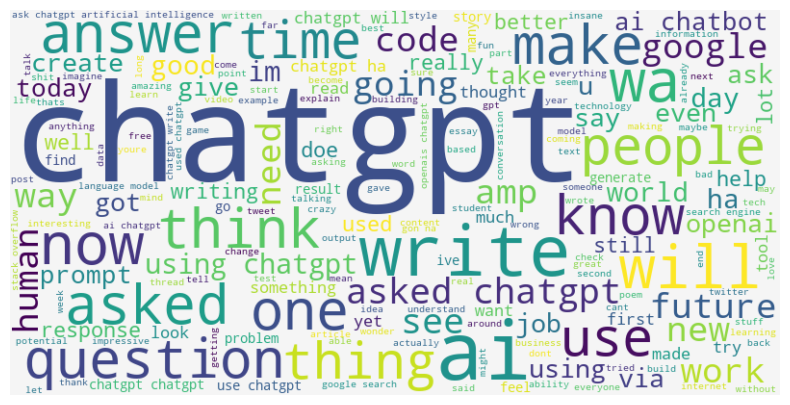

In [10]:
text_df = df['clean_data'].str.cat(sep=' ')

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=400, background_color='#F5F5F5').generate(text_df)

# Display the word cloud using Matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# **Splitting Data**

---

In [11]:
x_train, x_test, y_train, y_test = train_test_split(df.clean_data, df.labels, test_size=0.2, random_state=42)
print(f'# training data : {x_train.shape[0]}')
print(f'# testing data : {x_test.shape[0]}')

# training data : 96000
# testing data : 24000


## **Gnerating Training and Testing Data**

In [12]:
training_data=pd.DataFrame({'clean_data':x_train, 'labels':y_train[:]})
testing_data=pd.DataFrame({'clean_data':x_test, 'labels':y_test[:]})
training_data.to_csv('training_data.csv')
testing_data.to_csv('testing_data.csv')

# **Teks Procesing**

In [13]:
print(type(x_train))
print(type(x_train.iloc[0]))  # Mengecek tipe data dari elemen pertama

<class 'pandas.core.series.Series'>
<class 'str'>


In [14]:
num_of_words = 32000
max_num_of_words = 50 # in sequence
num_of_dimensions = 300  # For GloVe word embeddings

In [15]:
tokenizer = Tokenizer(num_words=num_of_words, filters=string.punctuation)
tokenizer.fit_on_texts(x_train)

# Menyimpan tokenizer ke file
import pickle
with open('tokenizer.pkl', 'wb') as handle:
    pickle.dump(tokenizer, handle)

x_train_sequences = tokenizer.texts_to_sequences(x_train)
x_test_sequences = tokenizer.texts_to_sequences(x_test)

data_description = x_train.apply(lambda x: len(x.split(' ')))
data_description_df = pd.DataFrame(data_description.describe())
data_description_df

,clean_data
count,96000.000000
mean,18.621990
std,12.959685
min,1.000000
25%,8.000000
50%,15.000000
75%,27.000000
max,61.000000


In [16]:
max_num_of_words = 49

x_train = pad_sequences(x_train_sequences, maxlen=max_num_of_words)
x_test = pad_sequences(x_test_sequences, maxlen=max_num_of_words)

print(f'Sample : {x_train.shape}')

Sample : (96000, 49)


## **Format Output**

In [17]:
label_encoder = LabelEncoder()
y_train = to_categorical(label_encoder.fit_transform(y_train))
y_test = to_categorical(label_encoder.transform(y_test))
y_test[0]

array([0., 1., 0.])

# **Glove Word Embeddings**

In [18]:
embedding_dict = {}
glove = open(f'glove.6B.300d.txt', encoding="utf8")
for line in glove:
  values = line.split()
  word = values[0]
  vector = np.asarray(values[1:], dtype='float32')
  embedding_dict[word] = vector
glove.close()

In [19]:
embedding_matrix = np.zeros((num_of_words, 300))

for w, i in tokenizer.word_index.items():
  if i < num_of_words:
    vect = embedding_dict.get(w)
    if vect is not None :
      embedding_matrix[i] = vect
  else:
    break

print('Embedding Matrix Shape: ', embedding_matrix.shape)

Embedding Matrix Shape:  (32000, 300)


# **Model Training**

In [20]:
# Function untuk Ploting nilai akurasi dan nilai loss

def plotting_model_measurements(history, model_name, trial_num):
  title_name = f'{model_name} Model (Trial-{trial_num})'
  fig, ax = plt.subplots(1,2, figsize=(10,4))
  fig.subplots_adjust(hspace=0.8, wspace=0.8)
  fig.suptitle(title_name, fontsize=16)
  fig.trial_num=trial_num

  ax[0].plot(history.history['accuracy'])
  ax[0].plot(history.history['val_accuracy'])
  ax[0].set_title('Model Accuracy')
  ax[0].set_xlabel('epoch')
  ax[0].set_ylabel('accuracy')
  ax[0].legend(['train', 'validation'], loc='best')
  ax[1].plot(history.history['loss'])
  ax[1].plot(history.history['val_loss'])
  ax[1].set_title('Model Loss')
  ax[1].set_xlabel('epoch')
  ax[1].set_ylabel('loss')
  ax[1].legend(['train', 'validation'], loc='best')
  #to_file=('/content/drive/MyDrive/Python/{model_name} Model Accuracy and Loss (Trial No.:{trial_num}).png')
  #plt.savefig(f'Images/{model_name} Model Accuracy and Loss (Trial No.:{trial_num}).png')
  plt.draw()
  plt.tight_layout()

## **CNN**

In [21]:
@tf.keras.utils.register_keras_serializable()
def precision_m(y_true, y_pred):
    true_positives = tf.reduce_sum(tf.cast(tf.round(tf.clip_by_value(y_true * y_pred, 0, 1)), tf.float32))
    predicted_positives = tf.reduce_sum(tf.cast(tf.round(tf.clip_by_value(y_pred, 0, 1)), tf.float32))
    precision = true_positives / (predicted_positives + tf.keras.backend.epsilon())
    return precision

@tf.keras.utils.register_keras_serializable()
def recall_m(y_true, y_pred):
    true_positives = tf.reduce_sum(tf.cast(tf.round(tf.clip_by_value(y_true * y_pred, 0, 1)), tf.float32))
    possible_positives = tf.reduce_sum(tf.cast(tf.round(tf.clip_by_value(y_true, 0, 1)), tf.float32))
    recall = true_positives / (possible_positives + tf.keras.backend.epsilon())
    return recall

@tf.keras.utils.register_keras_serializable()
def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + tf.keras.backend.epsilon()))


In [22]:
custom_objects={'f1_m': f1_m, 'precision_m': precision_m, 'recall_m': recall_m}

In [23]:
#from tensorflow.keras.regularizers import l2
from tensorflow.keras.regularizers import l1_l2

def buat_cnn(Conv1D_1, Conv1D_2, Conv1D_3, _learning_rate, embedding_trainable, model_name):
    model = models.Sequential(name=model_name)
    model.add(layers.Embedding(num_of_words, num_of_dimensions, input_length=max_num_of_words, name='embedding_Layer', weights=[embedding_matrix], trainable=embedding_trainable))
    
    if Conv1D_1:
        model.add(Conv1D(128, 16, padding='same', activation='relu'))
        model.add(MaxPooling1D(3))

    if Conv1D_2:
        model.add(Conv1D(128, 16, padding='same', activation='relu'))
        model.add(MaxPooling1D(3))

    if Conv1D_3:
        model.add(Conv1D(128, 16, padding='same', activation='relu'))
        model.add(MaxPooling1D(3))

    model.add(layers.Dropout(0.6))
    model.add(layers.Flatten())

    # L2 Regularization di Dense Layer
    model.add(Dense(64, activation='relu', kernel_regularizer=l1_l2(l1=0.001, l2=0.004)))
    model.add(layers.Dropout(0.3))

    model.add(Dense(32, activation='relu', kernel_regularizer=l1_l2(l1=0.001, l2=0.004)))
    model.add(layers.Dropout(0.2))

    model.add(Dense(3, activation='softmax', name='Output_Layer'))  # Output Layer

    model.layers[0].set_weights([embedding_matrix])
    
    if embedding_trainable:
        model.layers[0].trainable = True
    else:
        model.layers[0].trainable = False

    model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=_learning_rate), metrics=['accuracy', f1_m, precision_m, recall_m])

    model.summary()
    return model


In [24]:
cnn_model_trials_dict = {
    'Measurement' : ['Trial-1', 'Trial-2' , 'Trial-3', 'Trial-4', 'Trial-5'], # Trial-1 => 0 , Trial-2 => 1 , ...
             'Training Accuaracy' : [0,0,0,0,0],
             'Testing Accuaracy' : [0,0,0,0,0],
             'Loss' : [0,0,0,0,0],
             'Embedding layer Trainable':['No','No','No','No','No']
}

### **Training Model CNN**

In [25]:
# Trial-4 (embedding_trainable=True)

cnn_model_trial4 = buat_cnn(embedding_trainable=True, Conv1D_1=True, Conv1D_2=False, Conv1D_3=False, _learning_rate=0.001, model_name='CNN_Trial-4')
cnn_model_trial4_history = cnn_model_trial4.fit(x_train, y_train,epochs=10, verbose=1,batch_size=256,validation_split=0.2)

'''Plotting Model Architecture For Trial-4'''
tf.keras.utils.plot_model(cnn_model_trial4, show_shapes=True)
#plt.savefig('/content/drive/MyDrive/Python/CNN Model (Trial 4).png')

cnn_model_trials_dict['Embedding layer Trainable'][3]='Yes'

c:\Users\Lenovo\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "CNN_Trial-4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_Layer (Embedding)     │ ?                      │     9,600,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_Layer (Dense)            │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,600,000 (36.62 MB)

 Trainable params: 9,600,000 (36.62 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 382s 1s/step - accuracy: 0.5140 - f1_m: 0.3094 - loss: 2.5024 - precision_m: 0.5668 - recall_m: 0.2424 - val_accuracy: 0.8604 - val_f1_m: 0.8573 - val_loss: 0.6045 - val_precision_m: 0.8778 - val_recall_m: 0.8377
Epoch 2/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 326s 1s/step - accuracy: 0.8707 - f1_m: 0.8677 - loss: 0.5767 - precision_m: 0.8877 - recall_m: 0.8488 - val_accuracy: 0.9030 - val_f1_m: 0.9021 - val_loss: 0.4605 - val_precision_m: 0.9116 - val_recall_m: 0.8929
Epoch 3/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 349s 1s/step - accuracy: 0.9168 - f1_m: 0.9161 - loss: 0.4236 - precision_m: 0.9264 - recall_m: 0.9060 - val_accuracy: 0.9141 - val_f1_m: 0.9137 - val_loss: 0.4031 - val_precision_m: 0.9213 - val_recall_m: 0.9062
Epoch 4/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 411s 1s/step - accuracy: 0.9355 - f1_m: 0.9348 - loss: 0.3564 - precision_m: 0.9425 - recall_m: 0.9272 - val_accuracy: 0.9161 - val_f1_m: 0.9157 - val_loss: 0.3850 - val_precision_m: 0.9220 - val_recal

### **Testing Model CNN**

In [26]:
# Trial-4
training_score = cnn_model_trial4.evaluate(x_train, y_train)
testing_score = cnn_model_trial4.evaluate(x_test, y_test)

print(f'\nTrial 4')
print(f'Training Accuaracy (Trial 4): {round(training_score[1]*100,1)}%')
print(f'Testing Accuaracy (Trial 4): {round(testing_score[1]*100,1)}%')

'''   Save the data of trial 4 in cnn model trials dictionary   '''
cnn_model_trials_dict['Training Accuaracy'][3]=round(training_score[1]*100,1)
cnn_model_trials_dict['Testing Accuaracy'][3]=round(testing_score[1]*100,1)
cnn_model_trials_dict['Loss'][3] = round(testing_score[0], 2)

3000/3000 ━━━━━━━━━━━━━━━━━━━━ 101s 33ms/step - accuracy: 0.9748 - f1_m: 0.9749 - loss: 0.1939 - precision_m: 0.9771 - recall_m: 0.9727
750/750 ━━━━━━━━━━━━━━━━━━━━ 23s 31ms/step - accuracy: 0.9118 - f1_m: 0.9118 - loss: 0.4111 - precision_m: 0.9166 - recall_m: 0.9071

Trial 4
Training Accuaracy (Trial 4): 96.3%
Testing Accuaracy (Trial 4): 91.3%


# **Plotting accrurasi dan loss**

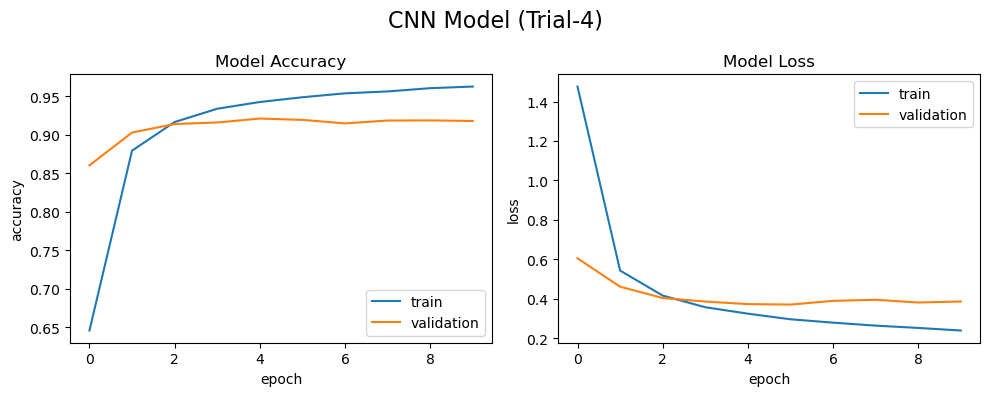

In [27]:
plotting_model_measurements(cnn_model_trial4_history,'CNN',4)

In [28]:
cnn_model_trial4.save('CNN_model_trial4.h5')

### **Prediksi Sentimen**

In [29]:
# Fungsi untuk memproses teks input
def preprocess_input_text(text):
    sequence = tokenizer.texts_to_sequences([text])
    padded_sequence = pad_sequences(sequence, maxlen=max_num_of_words)
    return padded_sequence

# Fungsi prediksi sentimen
def predict_sentiment(input_text):
    processed_input = preprocess_input_text(input_text)
    prediction = cnn_model_trial4.predict(processed_input)
    sentiment = np.argmax(prediction, axis=1)[0]  # Mendapatkan kelas prediksi (0, 1, atau 2)
    confidence = prediction[0][sentiment]  # Probabilitas kelas tertinggi
    if sentiment == 0:
        return "bad", confidence
    elif sentiment == 1:
        return "good", confidence
    else:
        return "neutral", confidence

# Contoh input
data_input = "chatgpt emerging ai threat landscape   trustwave"
predicted_sentiment, confidence = predict_sentiment(data_input)

print("Input:", data_input)
print("Predicted Sentiment:", predicted_sentiment)
print("Confidence:", round(confidence * 100, 2), "%")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step
Input: chatgpt emerging ai threat landscape   trustwave
Predicted Sentiment: bad
Confidence: 99.42 %
